# 1、（Vanilla）Convolution  (普通)卷积
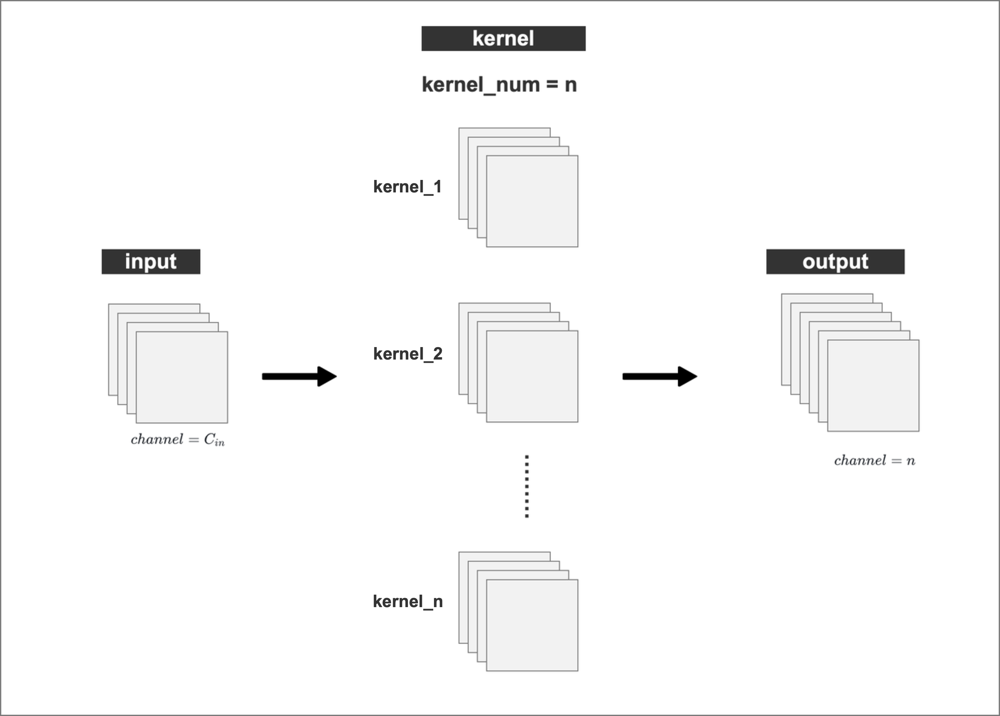

卷积输出的 尺寸的计算公式 ：

W_out = (W_in + 2P_w - K_w) / S_w + 1

H_out = (H_in + 2P_h - K_h) / S_h + 1

其中，输入的尺寸为(W_in,H_in),卷积核的尺寸为(K_w,K_h),步幅为(S_w,S_h),填充为(P_w,P_h),输出的尺寸为(W_out,H_out)

# 2、Group Convolution 分组卷积

Group convolution（分组卷积）最早是在AlexNet（Alex Krizhevsky等人于2012年提出的深度神经网络模型）中引入的。在 AlexNet中，作者们使用了分组卷积来将计算分布到多个GPU上。

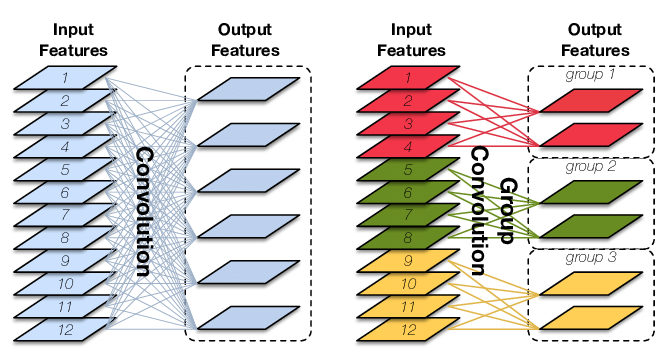

Group Convolution ：将输入 feature map 在 channel 的维度上进行分组，然后再对每个分组 分别进行卷积操作

Group Convolution 可减小参数量。 如下图，假设输入尺寸为 C_in × H × W，卷积核尺寸为 K × K，输出的 Channel 数为 n，我们分别使用 普通卷积 和 分组卷积来进行操作，并对比两种卷积方式的参数量 

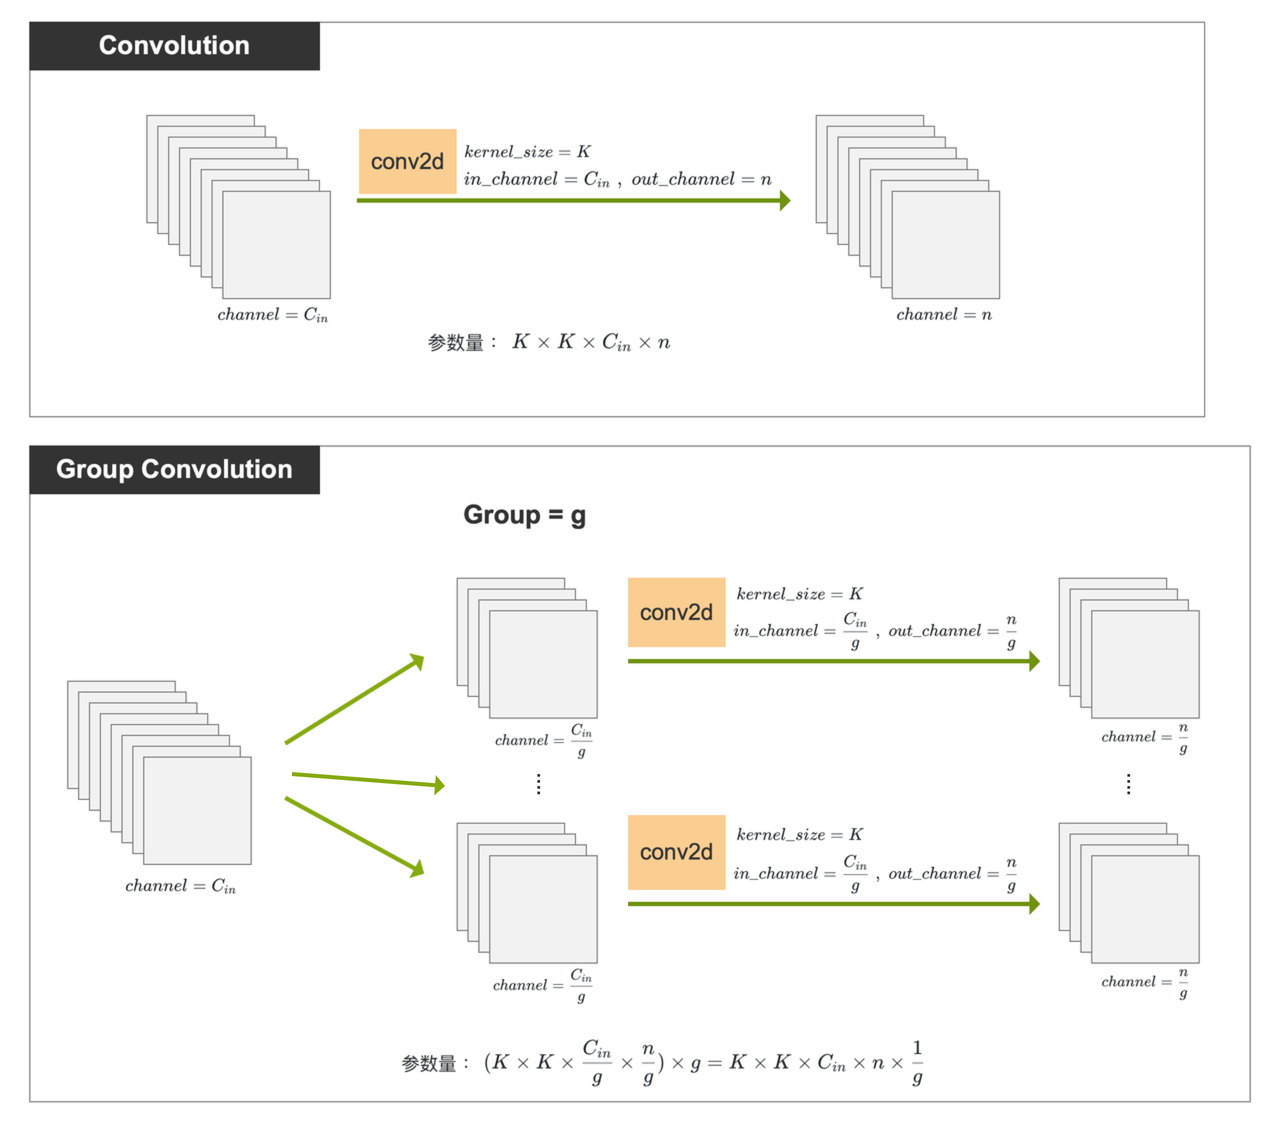

由上可知 ：Group Convolution 的参数量 是普通卷积参数量的 1/g

** 特殊情况 ： 当分组数量 g 等于输入channel 数量，Group Convolution 就等价于 Depthwise Convolution。

In [ ]:
#代码示例：
# 使用 torch.nn.conv2d()，并通过参数 groups 指定组数
# in_channels 和 out_channels 都必须可以被 groups 整除，否则会报错， 类似 ：ValueError: in_channels must be divisible by groups

import torch
import torch.nn as nn

conv = nn.Conv2d(in_channels=10, out_channels=15, kernel_size=3, groups=5, stride=1, padding=1)
output = conv(torch.rand(1, 10, 20, 20))
print(output.shape)   # torch.Size([1, 15, 20, 20])

# 3、Depth-wise Convolution  逐深度卷积
将输入图像 的每一个 channel 分别进行 卷积操作，卷积的 in_channel 和 out_channel 都为1

使用 DW Convolution，输出的 channel 和 输入 channel一样

当 group Convolution 的组数等于 输入 channel 时，即 g=C_in 时 ，就是 Depth-wise convolution 

优点 ：参数量和计算量小

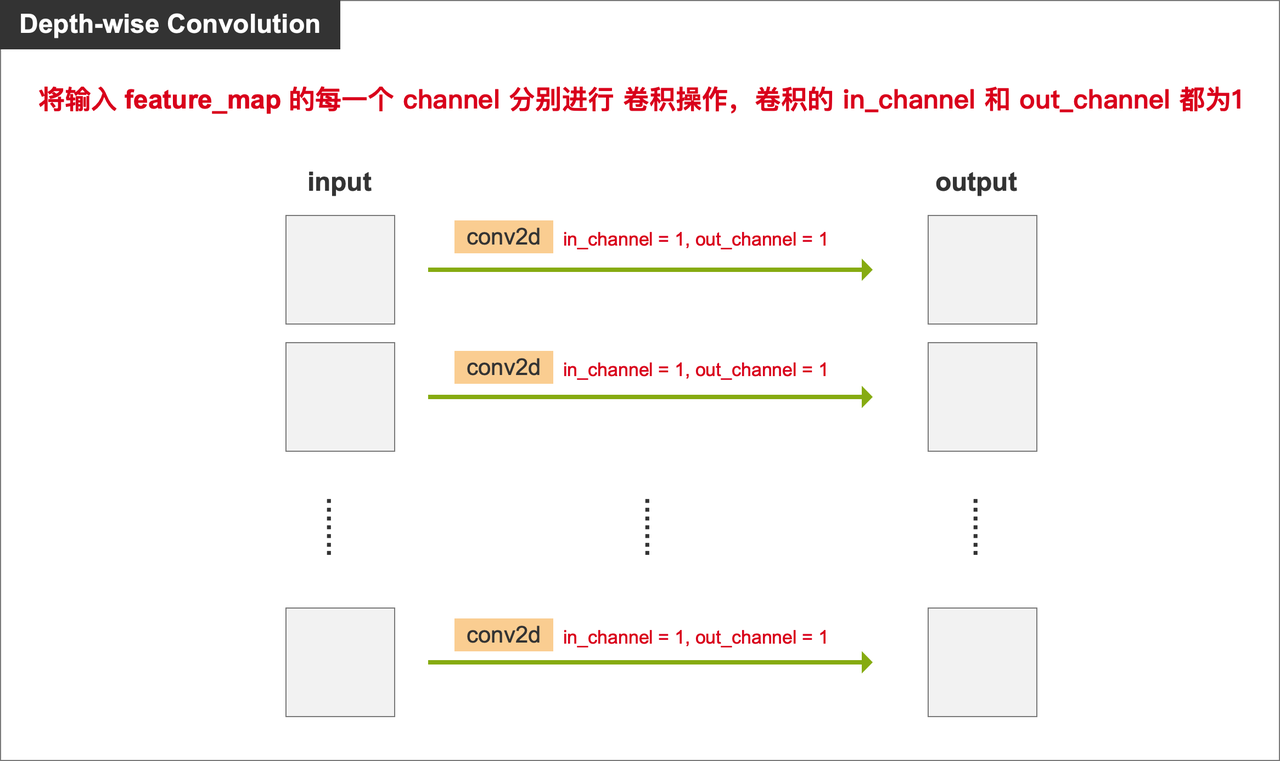

In [ ]:
# 代码示例 ： 将 nn.Conv2d 的参数 out_channels 和 groups 都设置为等于 in_channels
import torch
import torch.nn as nn

conv = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, groups=10, stride=1, padding=1)
output = conv(torch.rand(1, 10, 20, 20))
print(output.shape)   # torch.Size([1, 10, 20, 20])

# 4、Point-wise Convolution 逐点卷积
就是普通卷积，只不过 kernel_size=1x1，也就是我们经常看到的 conv 1x1， 它通常用来组合通道之间的特征信息

优点 ：参数量和计算量小

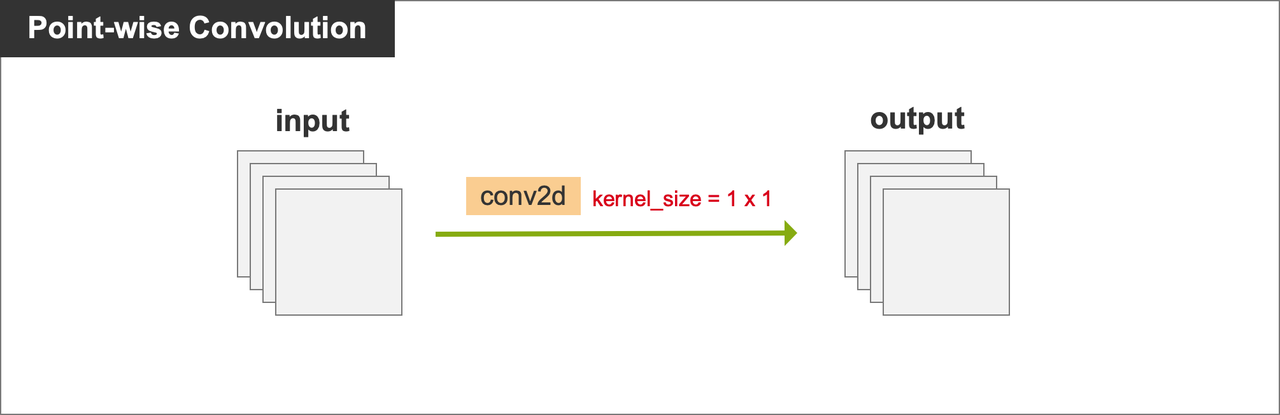

In [ ]:
# 代码示例 ： 将 nn.Conv2d 的参数 kernel_size 设置为等于 1
import torch
import torch.nn as nn

conv = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=1, stride=1)
output = conv(torch.rand(1, 10, 20, 20))
print(output.shape)   # torch.Size([1, 10, 20, 20])

# 5、Depth-wise Separable Convolution 深度可分离卷积

Depth-wise Separable Convolution（深度可分离卷积）最早是由Google的研究团队在2014年提出的。该方法首次出现在论文《MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications》中

Depth-wise Separable Convolution 就是先做一个 Depth-wise Convolution ，后面再做一个 Point-wise Convolution 

他的优势是 极大的减小了卷积的计算量
（1）对于普通卷积而言，计算量为 ： D_k * D_k * M * N * D_F * D_F

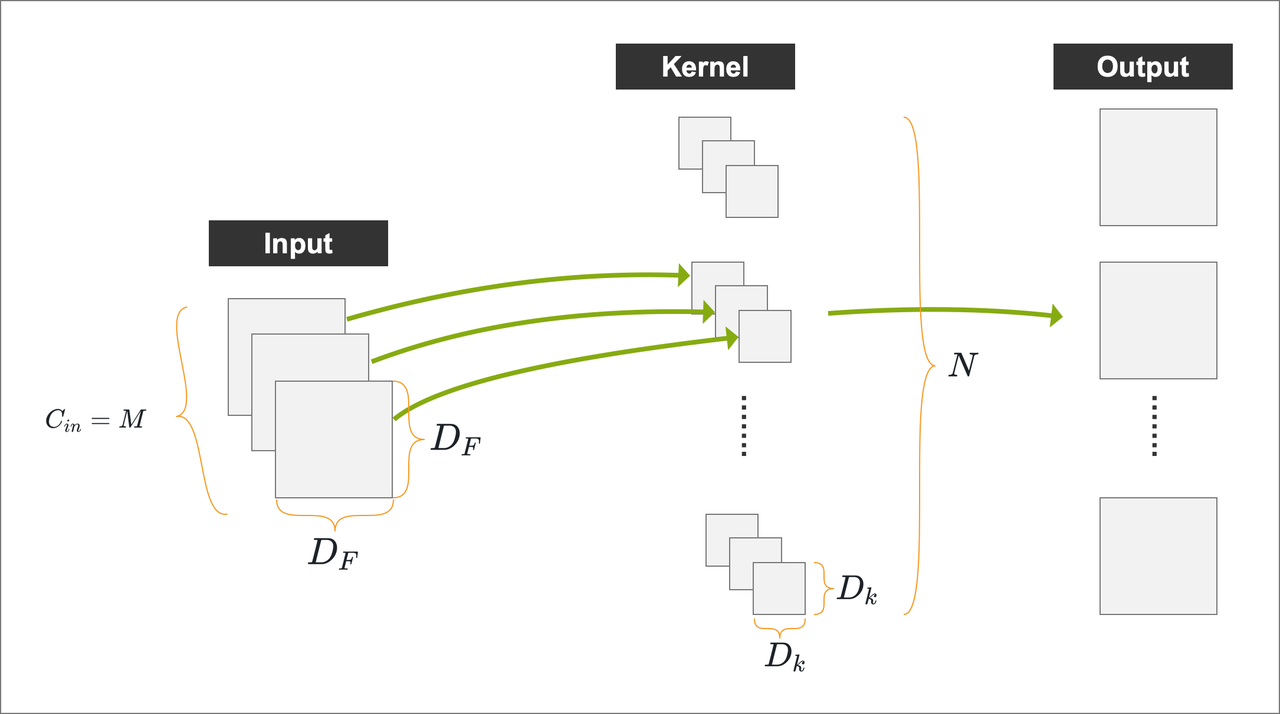

（2）Depth-wise Separable Convolution，计算量为 ： D_k * D_k * M * D_F * D_F + M * N * D_F * D_F

其中：

对于 Depth-wise Convolution，计算量为 ：D_k * D_k * M * D_F * D_F

对于 Point-wise Convolution ，计算量为 ：M * N * D_F * D_F

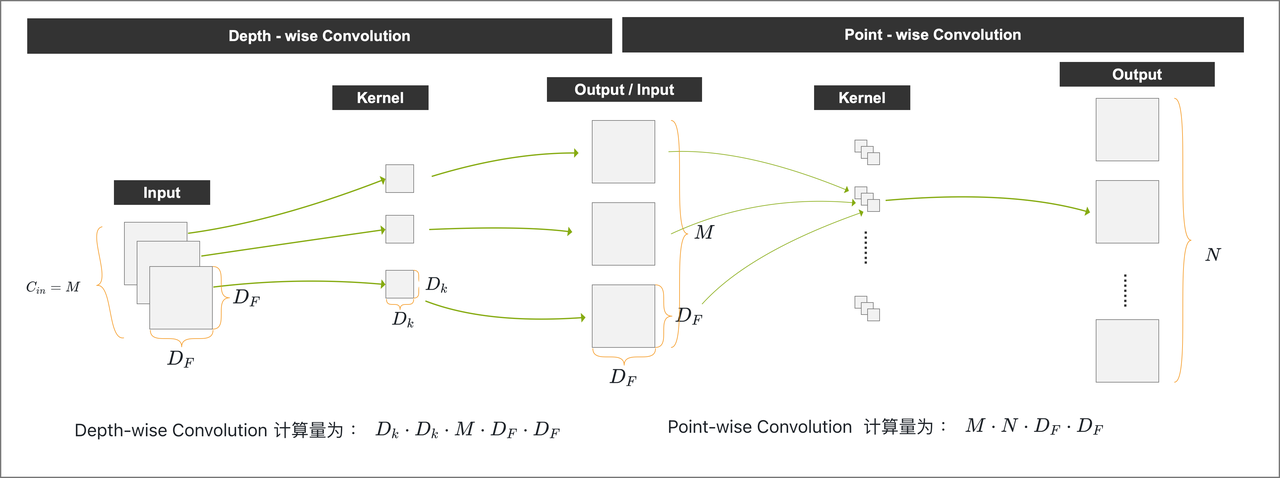

为了对比 普通卷积和深度可分离卷积的计算量，我们用公式(2) 除以公式(1) ：(D_k * D_k * M * D_F * D_F + M * N * D_F * D_F) / (D_k * D_k * M * N * D_F * D_F) = 1/N + 1/D_k^2 

通常，我们在使用卷积的时候，使用的最多的还是 3×3 的卷积，即D_k =3，所以，上面的公式(3)，一般等于：1/N + 1/D_k^2 = 1/N + 1/9

所以，理论上，普通卷积的计算量是 深度可分离卷积计算量的  8倍 ～ 9倍

# 6、Dilation Convolution 膨胀卷积
Dilation Convolution 称为 空洞卷积 或 膨胀卷积，其通过在卷积核的元素之间引入间隔（dilation），从而增大了卷积核的感受野。

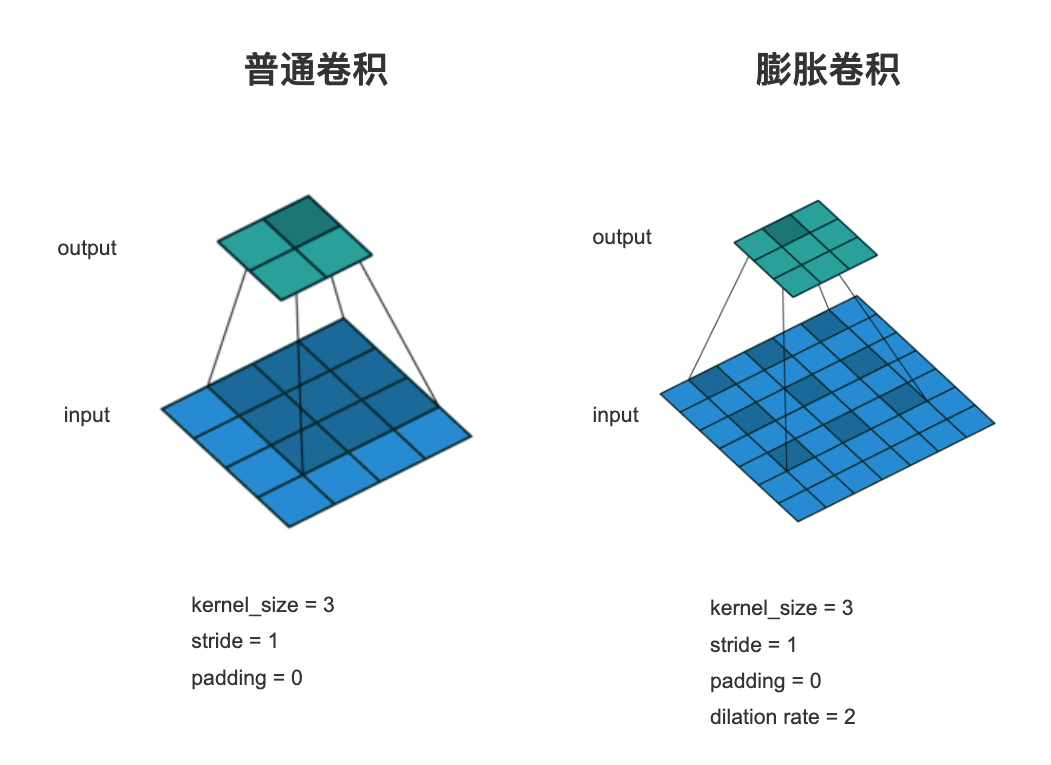

当 dilation=1 时，是普通卷积

当 dilation=2 时，卷积核元素中间间隔一个像素

依此类推

In [ ]:
# 代码示例：指定参数 dilation
import torch
import torch.nn as nn

conv = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=2, dilation=2)
output = conv(torch.rand(1, 10, 20, 20))
print(output.shape)   # torch.Size([1, 10, 20, 20])

# 7、Transposed Convolution  转置卷积
转置卷积也是卷积， 只不过转置卷积 是一种上采样操作

如下图的 转置卷积所示，输入图像尺寸为 2x2， 输出图像的尺寸为 4x4

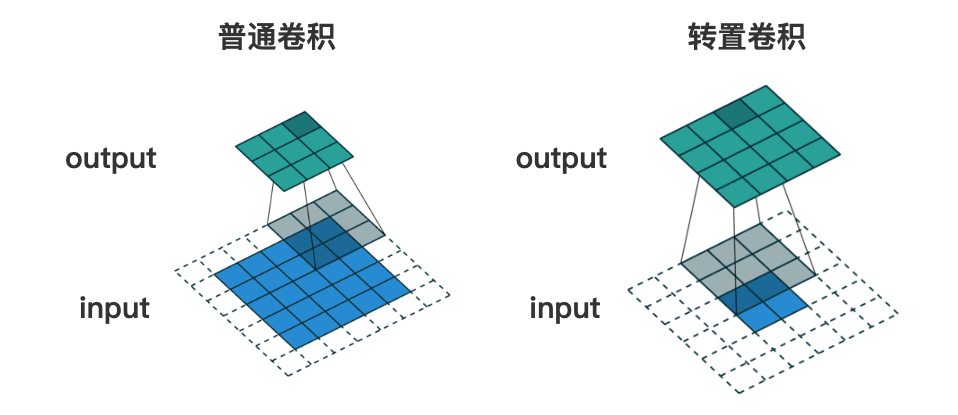

（1）如何设置 转置卷积 的 stride 和 padding 

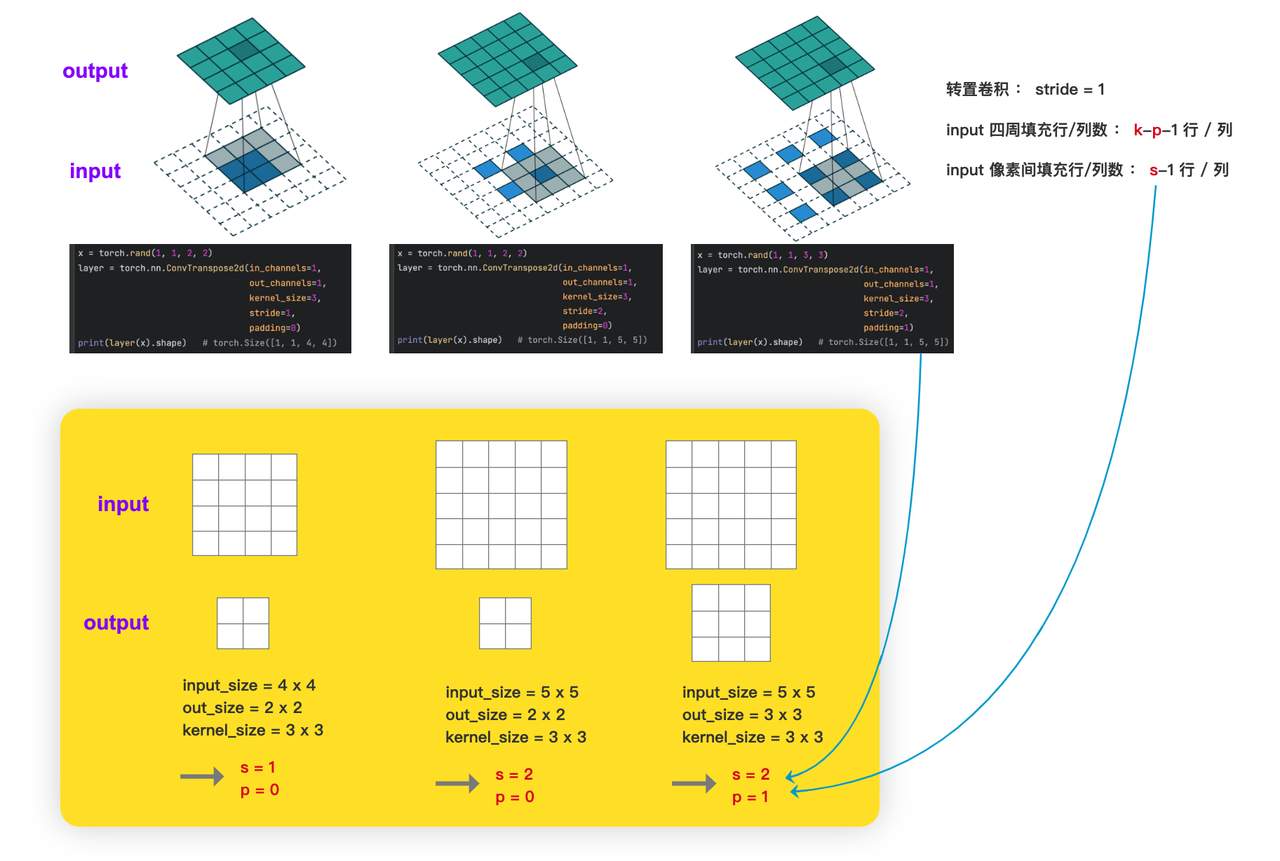

（2）已知 input 和 kernel，求 output

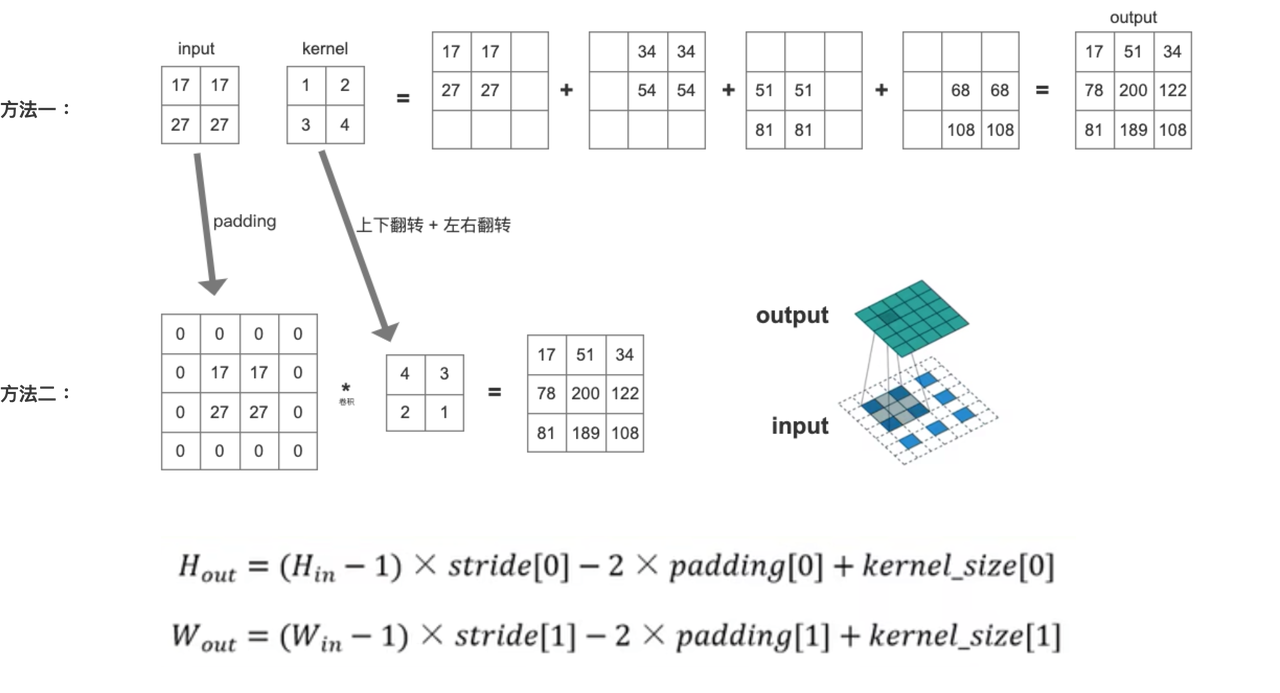

# 8、Deformable Convolution 可变形卷积
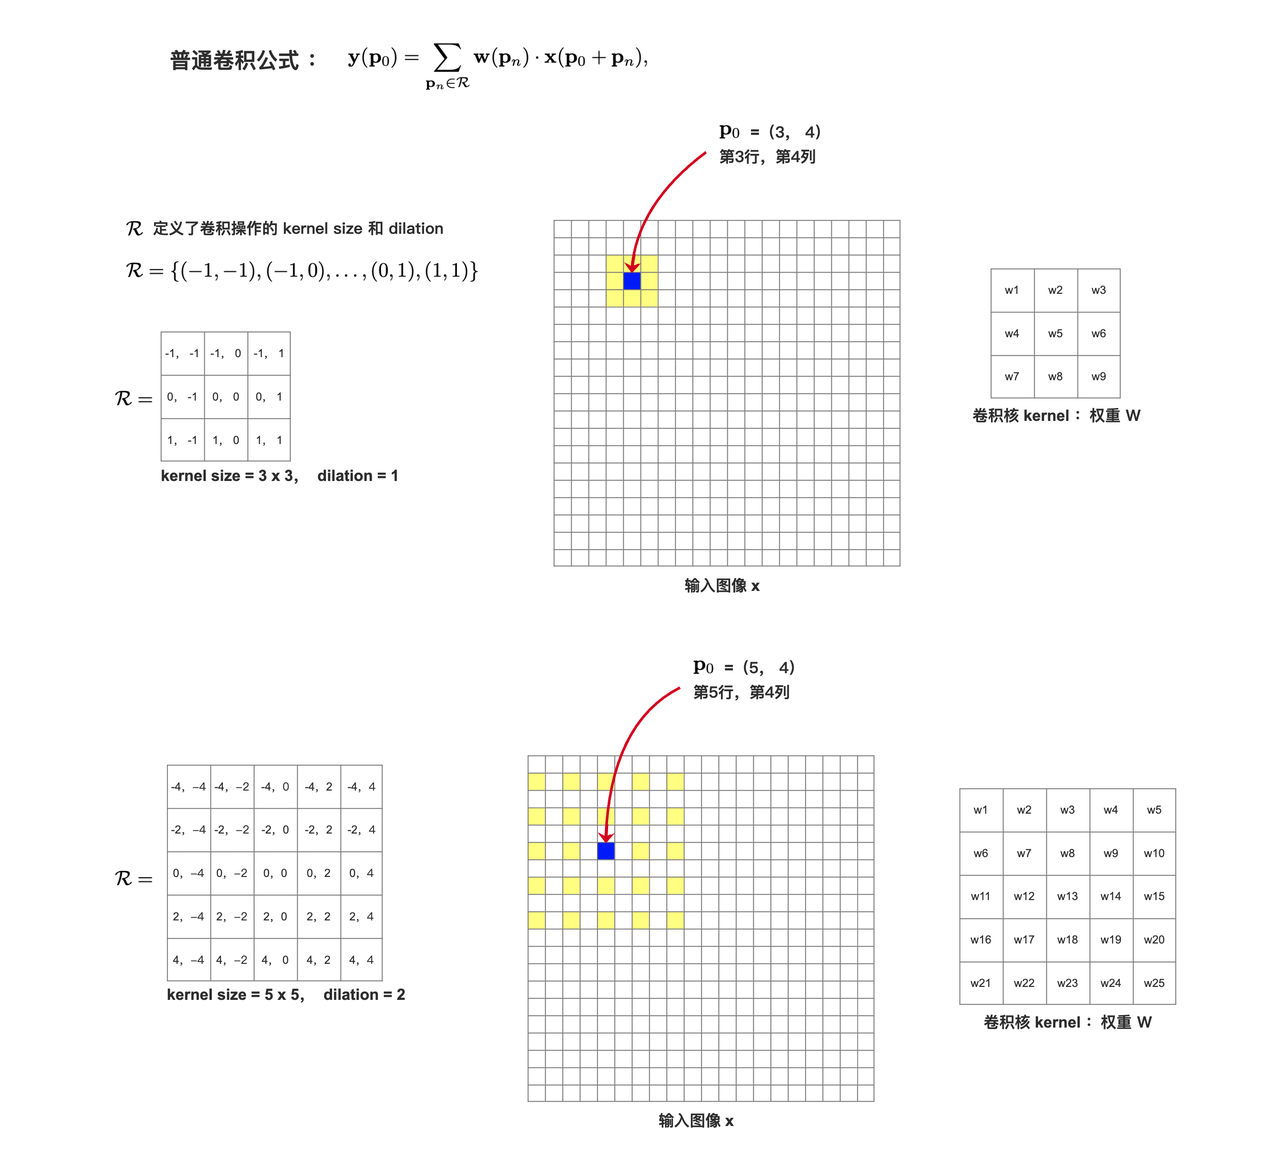

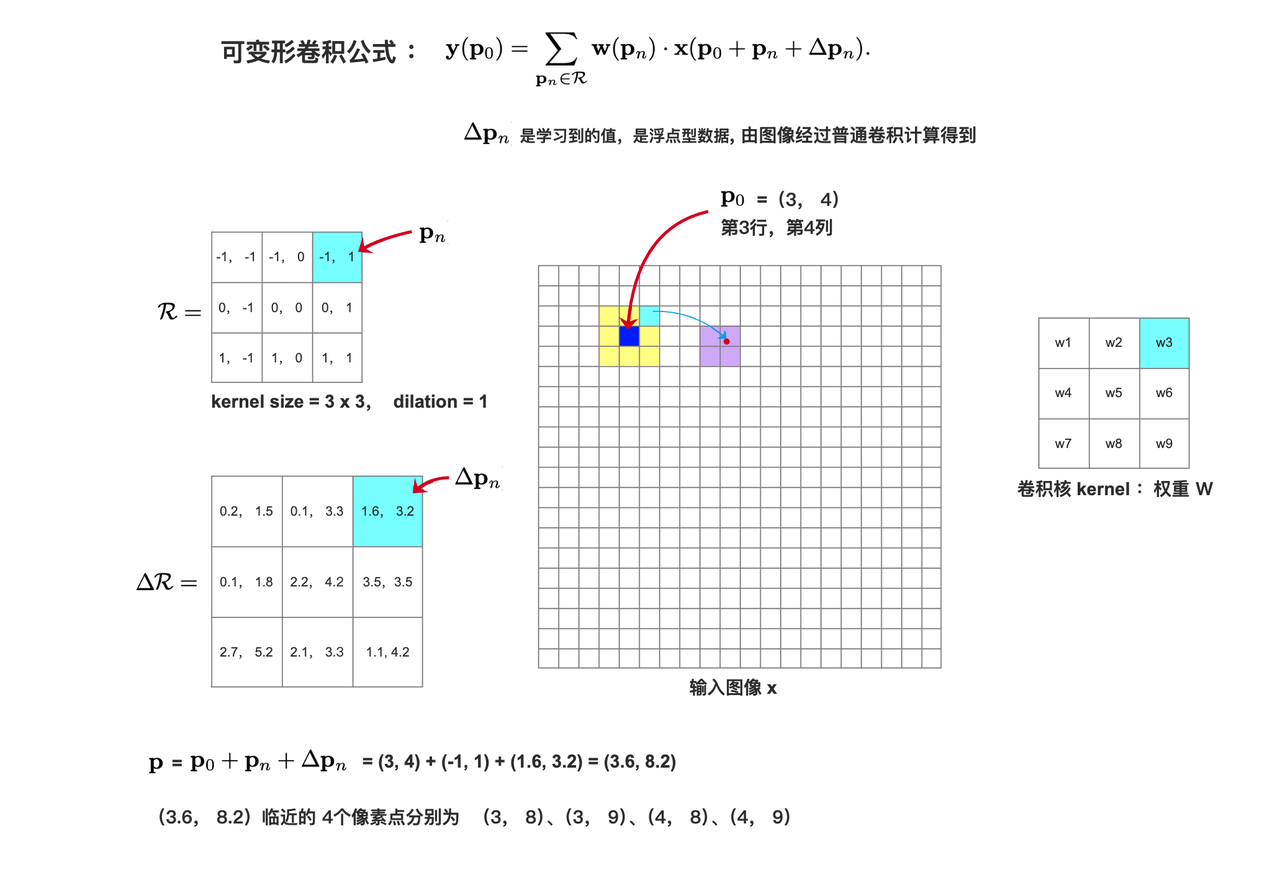

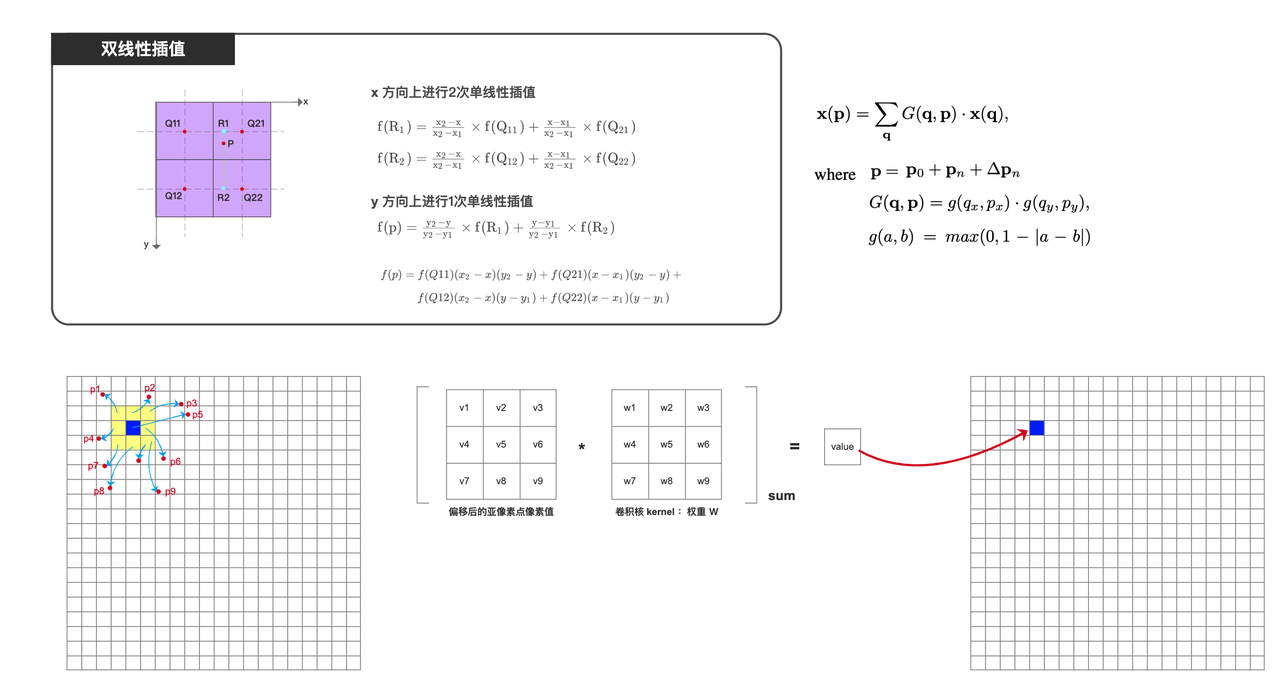